# WORLD Features Exploration
* Loads the pre-calculated WORLD features for a specified sample
* Visualise the features
* Investigate the impact of modifying the features on the synthesized speech

## 1) Setup

In [66]:
import sys
sys.path.append('..')
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio
import IPython.display

import phonemizer

import pandas as pd
from scipy.io import wavfile
import spectrogram as sp

import torch
import copy

In [67]:
os.chdir('/home/ubuntu/loop')
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

In [68]:
os.getcwd()

'/home/ubuntu/loop'

In [69]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

In [70]:
def trim_pred(out, attn):
    tq = attn.abs().sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [6]:
def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

In [7]:
def load_pre_calc_features(speaker_id, sample_id):
    pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

In [8]:
def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    
    if isinstance(feats, dict):
        feats = feats['audio_features']
    
    generate_merlin_wav(feats,
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data

In [9]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [53]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, checkpoint='models/vctk/bestmodel.pth', output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk/numpy_features'):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    model = Loop(train_args)
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    model.eval()

    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()

    # run loop model to generate output features 
    loop_feat, attn = model([txt, spkr], feat)
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    


    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict

In [11]:
def plot_attn(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    plt.figure(figsize=(6,6))
    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [12]:
def display_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

    # plot waveform
    plt.figure(figsize=(15,4))
    plt.plot(wav_data)
    plt.grid(True)
    plt.xlim(0, len(wav_data))
    plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

    # plot spectrogram
    plot_spectrogram(wav_data, rate)

In [13]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

In [14]:
 def plot_spectrogram_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    #loop_dict['output_orig_fname']
    #loop_dict['output_fname']
    
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    data_a = sp.butter_bandpass_filter(data_a, lowcut, highcut, rate_a, order=1)
    
    rate_b, data_b = wavfile.read(mywav_b)
    data_b = sp.butter_bandpass_filter(data_b, lowcut, highcut, rate_b, order=1)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    # create spectrograms
    wav_spectrogram_a = sp.pretty_spectrogram(data_a.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)

    wav_spectrogram_b = sp.pretty_spectrogram(data_b.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)
    
    # create mel spectrograms if necessary
    if b_mel:        
         # Generate the mel filters
        mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq, samplerate=rate_a) # may need to change sample rate
    
        # create mel spectrograms
        mel_spec_a = sp.make_mel(wav_spectrogram_a, mel_filter, shorten_factor = shorten_factor)
        mel_spec_b = sp.make_mel(wav_spectrogram_b, mel_filter, shorten_factor = shorten_factor)
        
        # use mel spectrograms in the plots (hacky, needs tidying up)
        wav_spectrogram_a = np.float64(mel_spec_a)
        wav_spectrogram_b = np.float64(mel_spec_b)

   
    # plot spectrograms and the differences
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_a + '(' + label_a + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_b + '(' + label_b + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b - wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Difference: (' + wav_file_b + ' - ' + wav_file_a + ') (' + label_b + ' - ' + label_a + ')')

In [15]:
def plot_waveform_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    
    rate_b, data_b = wavfile.read(mywav_b)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    max_a = data_a.max()
    min_a = data_a.min()
    max_b = data_b.max()
    min_b = data_b.min()
    
    max_both = max([max_a, max_b])
    min_both = min([min_a, min_b])
    
    plt.figure(figsize=(15,6))
    
    ax = plt.subplot(3, 1, 1)
    plt.plot(data_a)
    plt.grid(True)
    plt.xlim(0, len(data_a))
    plt.ylim(min_both, max_both)
    plt.gca().set_xticks(range(0,len(data_a), rate_a), range(0, np.int(np.ceil(1.0*len(data_a)/rate_a))))
    plt.title(label_a)
    plt.ylabel('Amplitude')
    
    ax = plt.subplot(3, 1, 2)
    plt.plot(data_b)
    plt.grid(True)
    plt.xlim(0, len(data_b))
    plt.ylim(min_both, max_both)
    ax.set_xticks(range(0,len(data_b), rate_b), range(0, np.int(np.ceil(1.0*len(data_b)/rate_b))))
    plt.title(label_b)
    plt.ylabel('Amplitude')
    
    ax = plt.subplot(3, 1, 3)
    plt.plot(data_b - data_a)
    plt.grid(True)
    plt.xlim(0, len(data_b))
    plt.ylim(min_both, max_both)
    ax.set_xticks(range(0,len(data_b), rate_b), range(0, np.int(np.ceil(1.0*len(data_b)/rate_b))))
    plt.title('Diff: ' + label_b + ' - ' + label_a)
    plt.ylabel('Amplitude')


In [16]:
def plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot mgc features
    plt.figure(figsize=(20,20))
    for x in range(60):
        plt.subplot(10, 6, x+1)
        plt.plot(feats_a[:, x])
        plt.plot(feats_b[:, x])
        plt.title('mgc' + str(x))
        if x == 5:
            plt.legend([label_a, label_b])
        if x < 6*9:
            plt.gca().get_xaxis().set_visible(False)
        if not np.mod(x, 6) == 0:
            plt.gca().get_yaxis().set_visible(False)

    plt.suptitle('mgc features', fontsize=14)
    plt.show()

In [17]:
def plot_other_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats_a[:, 60])
    plt.plot(feats_b[:, 60])
    plt.title('vuv')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 2)
    plt.plot(feats_a[:, 61])
    plt.plot(feats_b[:, 61])
    plt.title('lf0')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 3)
    plt.plot(feats_a[:, 62])
    plt.plot(feats_b[:, 62])
    plt.title('bap')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.show()

#### Speaker ID mappings

In [18]:
# Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
# should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

In [19]:
# load VCTK speaker_info metadata
speaker_info = get_vtck_speaker_info()
#speaker_info[speaker_info.id.isin(speaker_lookup.values())]
tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
pd.merge(speaker_info, tmp)

id  age gender   accents          region
0   294   33      F  American   San Francisco
1   297   20      F  American        New York
2   299   25      F  American      California
3   300   23      F  American      California
4   301   23      F  American  North Carolina
5   305   19      F  American    Philadelphia
6   306   21      F  American        New York
7   308   18      F  American         Alabama
8   310   21      F  American       Tennessee
9   311   21      M  American            Iowa
10  318   32      F  American            Napa
11  329   23      F  American                
12  330   26      F  American                
13  333   19      F  American         Indiana
14  334   18      M  American         Chicago
15  339   21      F  American    Pennsylvania
16  341   26      F  American            Ohio
17  345   22      M  American         Florida
18  360   19      M  American      New Jersey
19  361   19      F  American      New Jersey
20  362   29      F  American

## 2) Synthesize Speech Using VoiceLoop
* Specify a trained VoiceLoop model checkpoint
* Choose to synthesize the text in an existing VCTK file, or specify a free text string
* Choose which speaker's voice to use when synthesizing the speech

#### Define model to use

In [20]:
output_dir = './'
output_file = 'test.wav'



#checkpoint = 'checkpoints/vctk/lastmodel.pth'
checkpoint = 'models/vctk/bestmodel.pth'
#checkpoint = 'checkpoints/vctk-deleteme/lastmodel.pth'
#checkpoint = '/home/ubuntu/original-loop/checkpoints/vctk-original/lastmodel.pth'

norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'

#### Define text to synthesize

id  age gender   accents region
330  330   26      F  American

We talk about Mr Michael Johnson, and he is awesome.


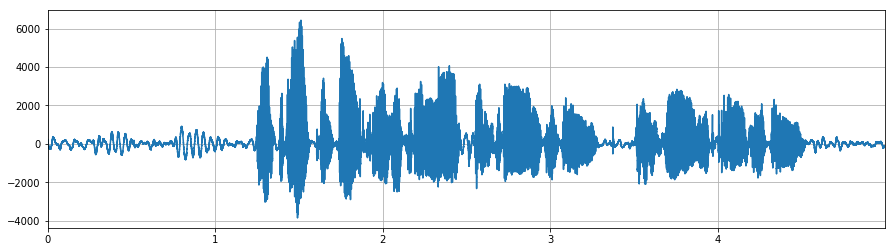

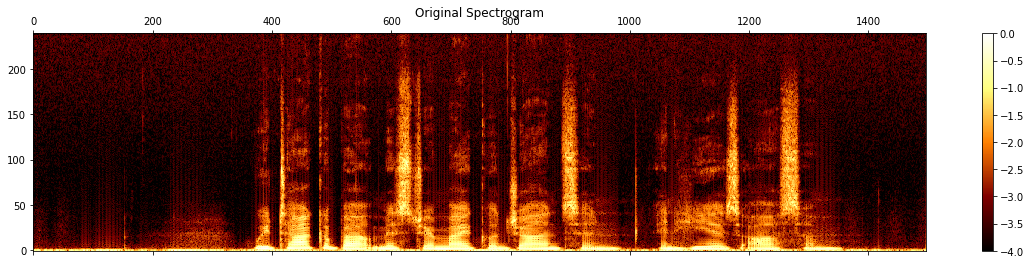

In [22]:
#
b_gen_from_text = False

if b_gen_from_text:
    # generate from free text
    text = 'see that girl watch that scene'
    npz_file = ''
    
else:
    # generate based on an existing VCTK sample
    source_speaker_id = 12
    sample_id = 230
    text = ''

    vctk_source_speaker_id = int(speaker_lookup[source_speaker_id])
    npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'
    
    # display/listen to the VCTK sample
    display_vctk_sample(vctk_source_speaker_id, sample_id)

#### Define which voice to use for synthesis

In [23]:
# speaker id to use for VoiceLoop generation
gen_speaker_id = 14

speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]]

id  age gender   accents   region
334  334   18      M  American  Chicago

#### Synthesize the sample with the specified speaker

In [24]:
# generate the sample
loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


In [25]:
# listen to sample synthesized with original WORLD features
if b_gen_from_text==False:
    IPython.display.display(Audio(loop_dict['output_orig_fname'] + '.wav', autoplay=True))

In [26]:
# listen to sample synthesized from VoiceLoop features
Audio(loop_dict['output_file'] + '.wav', autoplay=True)

## 3) Comparison of Speech Samples
* Listen to and visualise the differences between speech for the same text but generated in different ways, or with different speaker voices
* a) First pick which samples you want to compare
* c) Then run various comparisons 

### a) Pick Voice Samples
#### i) Compare the VoiceLoop Sample to the Original (same speaker)
* Run either i) or ii)
* Then move on to part b)

In [27]:
assert not b_gen_from_text, "Only works for synthesis based on VCTK samples"
loop_dict = generate_sample_with_loop(spkr_id=source_speaker_id, npz=npz_file, text='', checkpoint=checkpoint)
fname_a = loop_dict['output_orig_fname']
fname_b = loop_dict['output_file']
feats_a = loop_dict['feat'].squeeze()
feats_b = loop_dict['loop_feat'].squeeze()
label_a = 'WORLD'
label_b = 'Loop_SameSpkr'

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


#### ii) Compare VoiceLoop sample generated for a different speaker to the original VCTK sample

In [36]:
assert not b_gen_from_text, "Only works for synthesis based on VCTK samples"
loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text='', checkpoint=checkpoint)
fname_a = loop_dict['output_orig_fname']
fname_b = loop_dict['output_file']
feats_a = loop_dict['feat'].squeeze()
feats_b = loop_dict['loop_feat'].squeeze()
label_a = 'WORLD'
label_b = 'Loop_DiffSpkr'

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


#### iii) Compare two VoiceLoop samples, once generate in original speaker's voice and the other with a different speaker

In [54]:
loop_dict_source = generate_sample_with_loop(spkr_id=source_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)
fname_a = loop_dict_source['output_file']
feats_a = loop_dict_source['loop_feat'].squeeze()

loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)
fname_b = loop_dict['output_file']
feats_b = loop_dict['loop_feat'].squeeze()

label_a = 'Loop_OriginalSpkr'
label_b = 'Loop_DiffSpkr'

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_12.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_14.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


In [56]:
fname_b

'p330_230_14'

### b) Compare the Speech Samples
#### i) Listen to the audio

##### Original Sample

In [57]:
IPython.display.display(Audio(fname_a + '.wav', autoplay=True))

##### Test Sample

In [58]:
IPython.display.display(Audio(fname_b + '.wav', autoplay=True))

In [39]:
# the pre-calculated WORLD features from the .npz file
#loop_dict['pre_calc_feat'].keys()

#### ii) Spectrogram Comparison

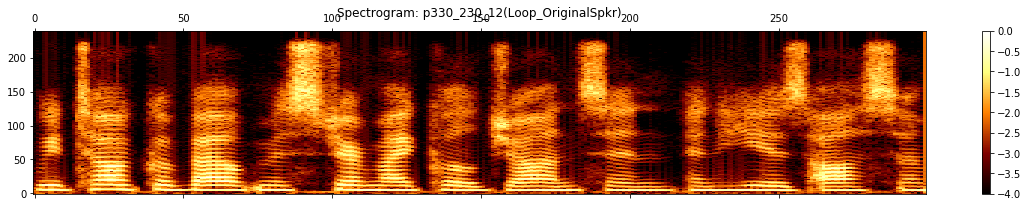

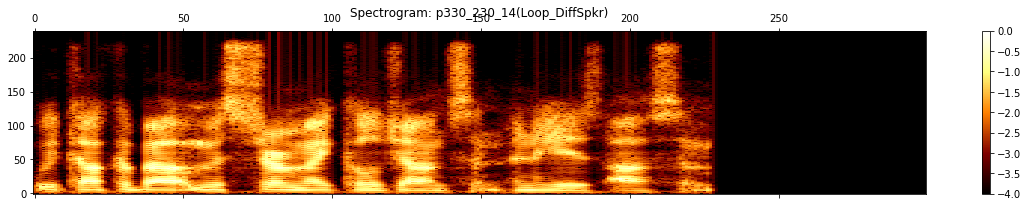

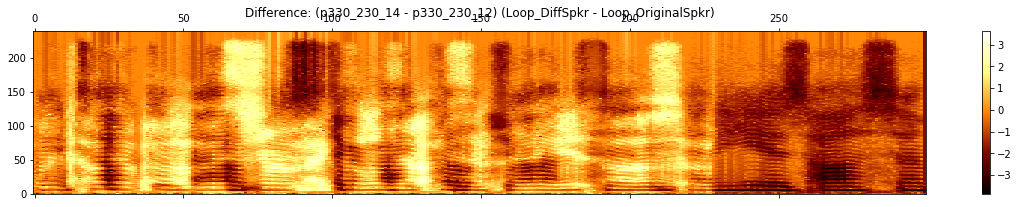

In [59]:
plot_spectrogram_comparison(fname_a, fname_b, label_a, label_b, b_mel=False)

#### iii) Feature Comparison

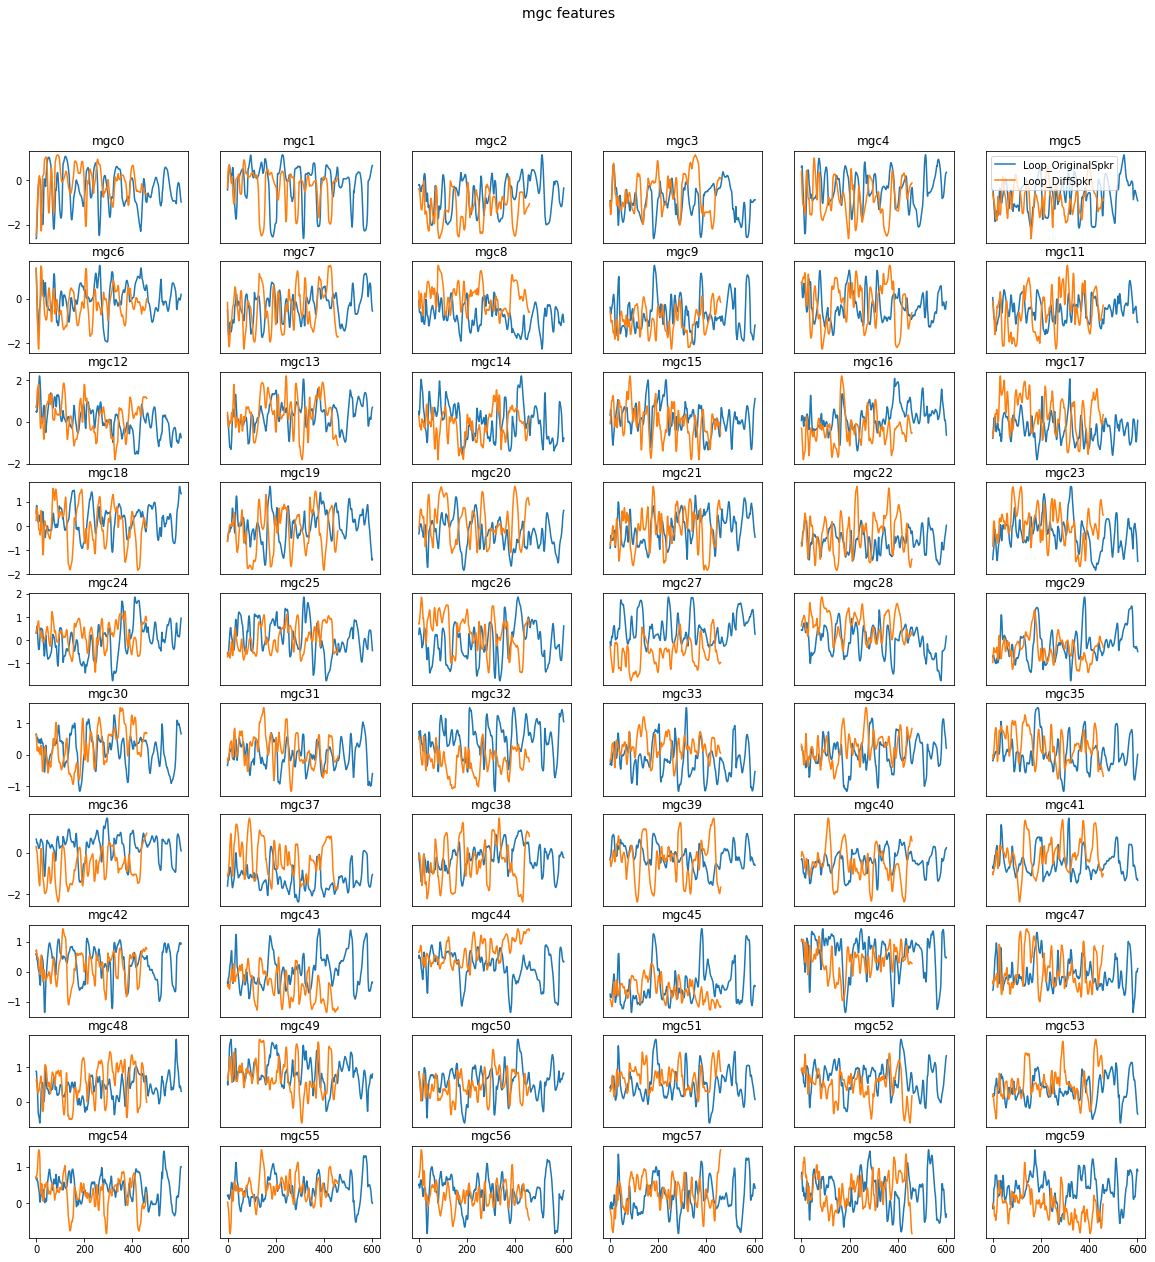

In [60]:
plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b)

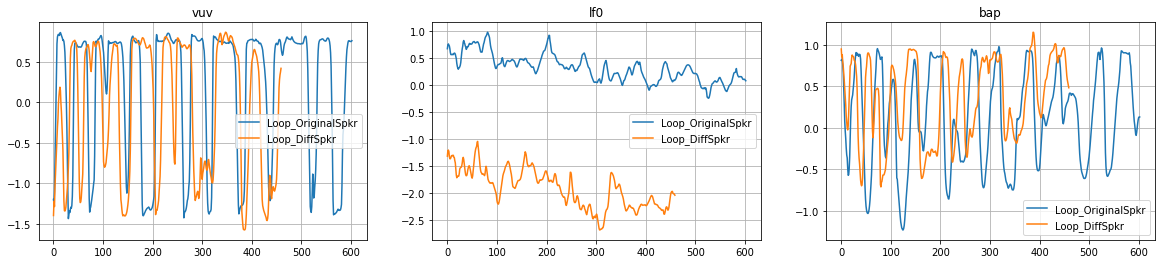

In [61]:
plot_other_feature_comparison(feats_a, feats_b, label_a, label_b)

#### iv) Attention Comparison

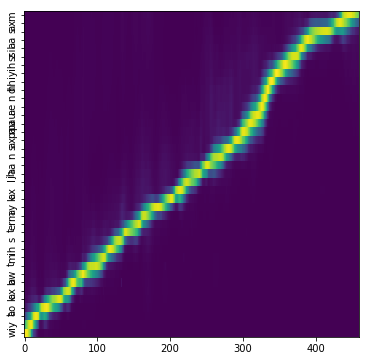

In [62]:
plot_attn(loop_dict['attn'], loop_dict['txt'], NpzFolder(loop_dict['valid_dataset_path']).dict)

## 4) Hack Features & Listen to the Impact
* Take the original WORLD features for an utterance
* Modify them manually
* Synthesize the results and compare to the original
* Note that none of this section uses the VoiceLoop code

#### Method 1) Deterministic modification to single feature

In [64]:
# hack methods
flat = lambda x: np.zeros(x.shape)

sq = lambda x, y, add=1, mult=1: add*x + mult * np.square(np.linspace(0, y, x.shape[0]))

power_hack = lambda x, scale=1, add=1, p=2, mult=1, shift=0: add*x + mult* np.power(np.linspace(-scale, scale, x.shape[0]), p) + shift

In [66]:
hack_method = power_hack

# specify which feature to hack
idx_feat_to_hack = 61 # lf0
#idx_feat_to_hack = 2 # mgc1
#idx_feat_to_hack = 60 # vuv
#idx_feat_to_hack = 62 # bap

# specify hack method

hack_args = [1, 2, 0, 0, 0] # scale, add, power, mult, shift
hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift
hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift


idx_feat_to_hack = 60 # vuv
hack_args = [1, 0, 0, 0, -1] # scale, add, power, mult, shift
hack_args = [1, 0, 0, 0, 1] # scale, add, power, mult, shift
hack_args = [1, 0, 1, -10, 0] # scale, add, power, mult, shift
#hack_args = [1, 1, 0, 0, 0] # scale, add, power, mult, shift

idx_feat_to_hack = 61 # lf0
#hack_args = [1, 2, 0, 0, 0] # scale, add, power, mult, shift
#hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift
hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift

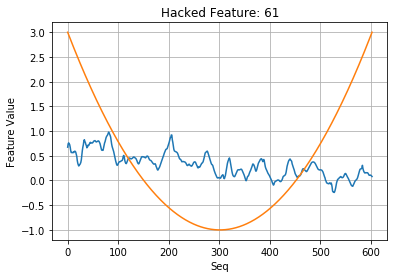

In [67]:
# modify feature values
hack_feat = copy.deepcopy(feats_a)
hack_feat[:, idx_feat_to_hack] = hack_method(hack_feat[:, idx_feat_to_hack], *hack_args)

plt.plot(feats_a[:, idx_feat_to_hack])
plt.plot(hack_feat[:, idx_feat_to_hack])
plt.grid(True)
plt.xlabel('Seq')
plt.ylabel('Feature Value')
plt.title('Hacked Feature: ' + str(idx_feat_to_hack))

output_file_hack = output_file + '_hack'

#### Method 2) Add random noise to all features

In [76]:
# add normal noise to all features
std = 0.05

# modify feature values
hack_feat = copy.deepcopy(feats_a)

for i in range(feats_a.shape[1]):
    # random noise at each time step
    #hack_feat[:, i] += np.random.normal(size=feats_a.shape[0], scale=std, loc=0)
    
    # cumulative noise
    hack_feat[:, i] += np.cumsum(np.random.normal(size=feats_a.shape[0], scale=std, loc=0))

output_file_hack = output_file + '_hack'

### Generate .wav file from modified WORLD features

In [77]:
generate_merlin_wav(hack_feat[:, :],
                    output_dir,
                    output_file_hack,
                    norm_path)

Audio(output_file_hack + '.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav_hack.wav.


In [78]:
# original
IPython.display.display(Audio(fname_a + '.wav', autoplay=True))

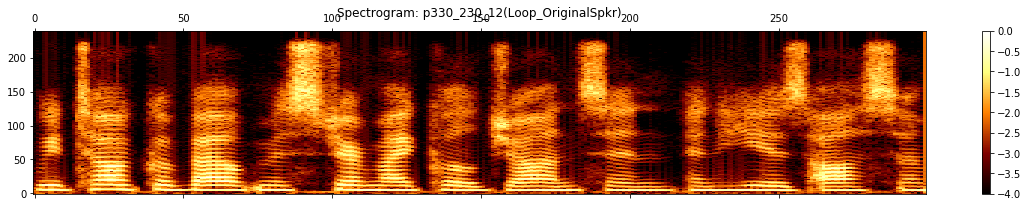

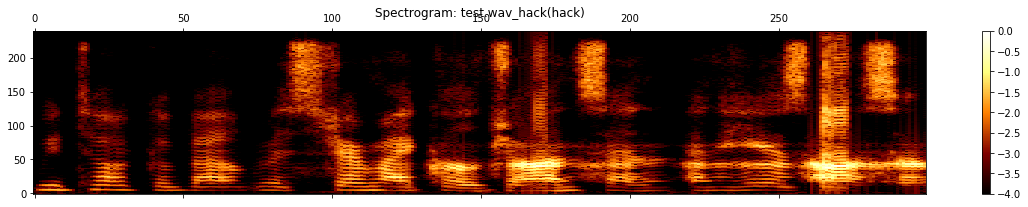

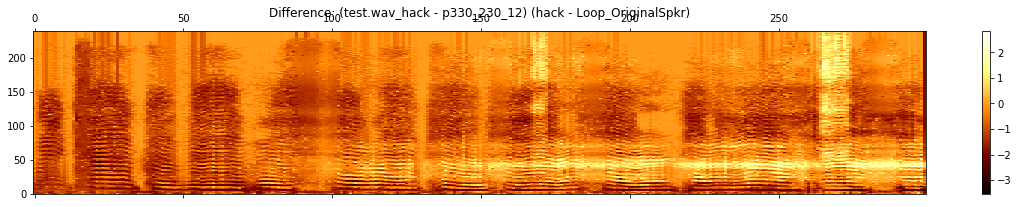

In [79]:
plot_spectrogram_comparison(fname_a, output_file_hack, label_a, 'hack', b_mel=False)

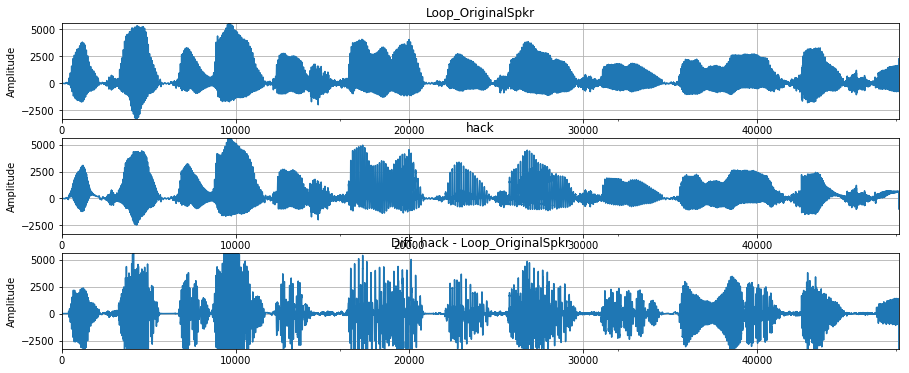

In [71]:
plot_waveform_comparison(fname_a, output_file_hack, label_a, 'hack')

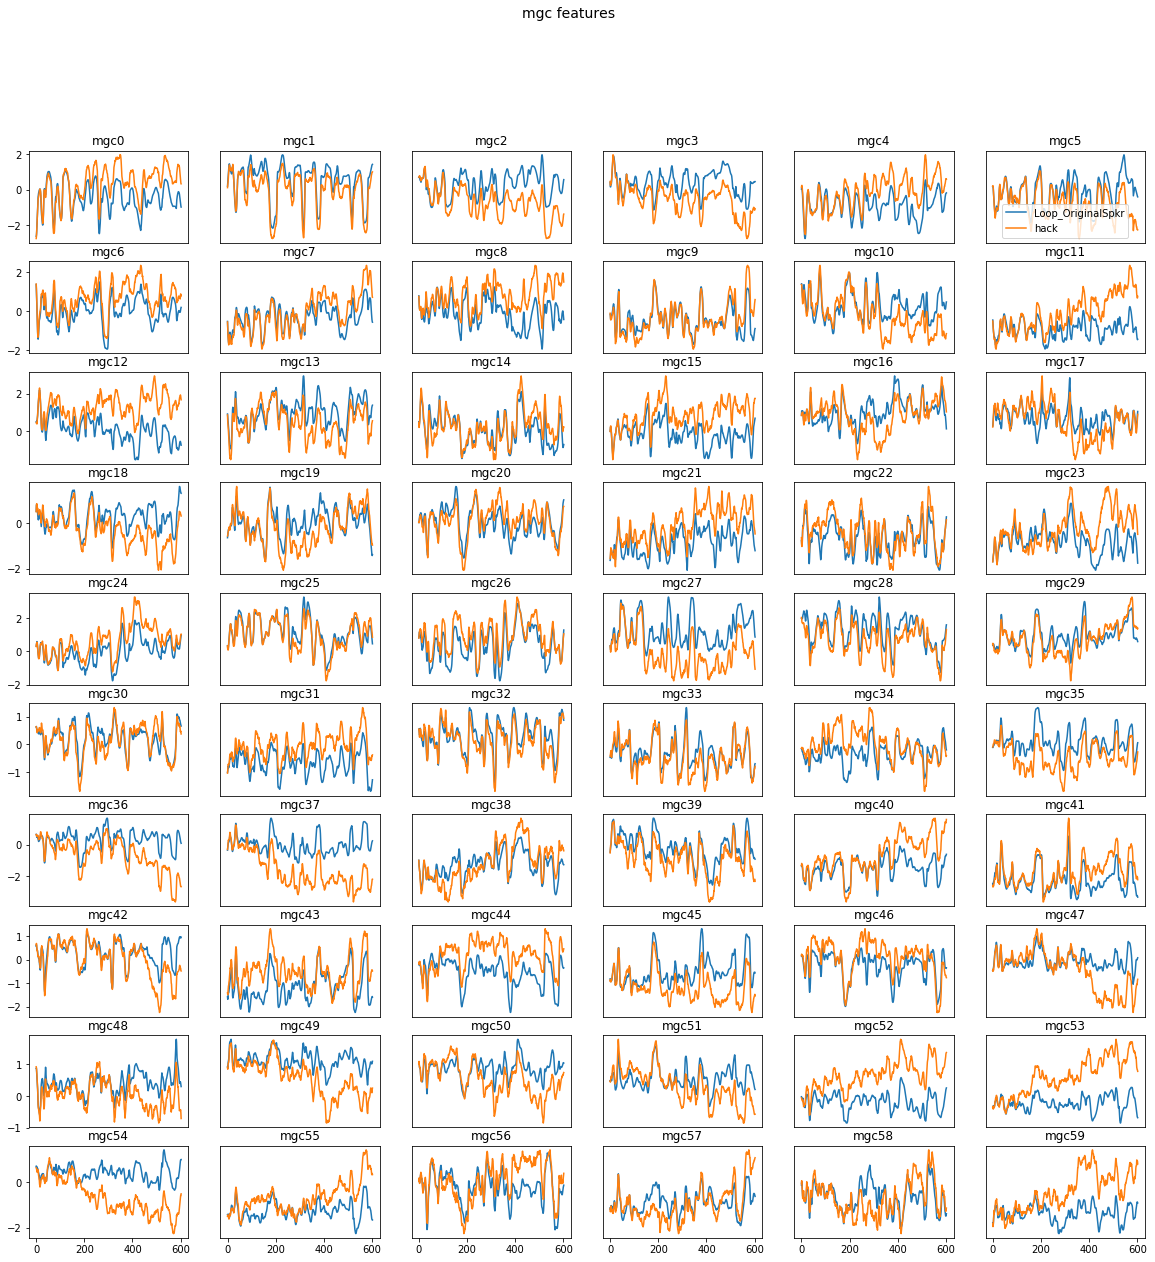

In [80]:
plot_mgc_feature_comparison(feats_a, hack_feat, label_a, 'hack')

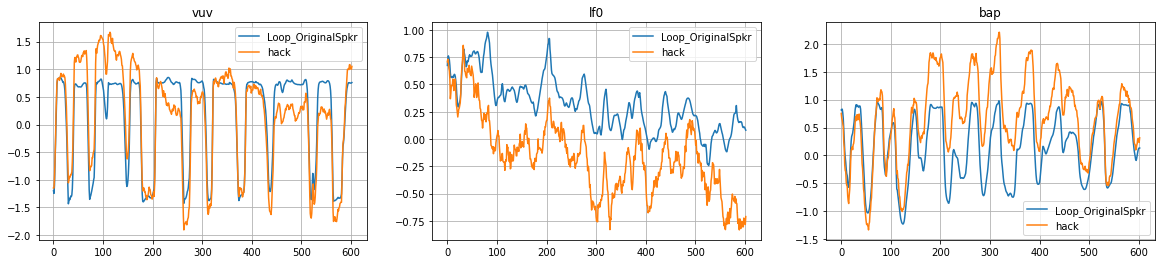

In [81]:
plot_other_feature_comparison(feats_a, hack_feat, label_a, 'hack')